In [29]:
import vae_EUCL
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [30]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                              download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=256, shuffle=True)


In [31]:
model = vae_EUCL.VariationalAutoencoder(latent_dims=4)

In [32]:
learning_rate = 1e-3

In [33]:
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [34]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [35]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [36]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = valset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 51837.582031
	 partial train loss (single batch): 50652.246094
	 partial train loss (single batch): 49748.664062
	 partial train loss (single batch): 48945.398438
	 partial train loss (single batch): 48233.335938
	 partial train loss (single batch): 47576.492188
	 partial train loss (single batch): 47018.441406
	 partial train loss (single batch): 46514.640625
	 partial train loss (single batch): 46175.226562
	 partial train loss (single batch): 45779.828125
	 partial train loss (single batch): 45430.765625
	 partial train loss (single batch): 45020.210938
	 partial train loss (single batch): 44835.152344
	 partial train loss (single batch): 44403.441406
	 partial train loss (single batch): 44232.765625
	 partial train loss (single batch): 43901.085938
	 partial train loss (single batch): 43805.980469
	 partial train loss (single batch): 43437.609375
	 partial train loss (single batch): 43300.917969
	 partial train loss (single batch): 42994.046875


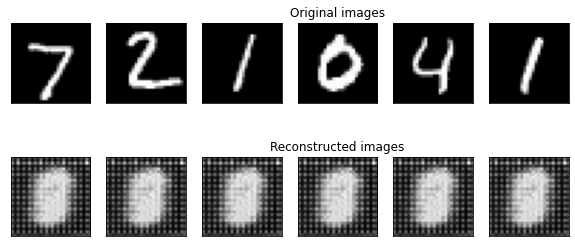

	 partial train loss (single batch): 16821.253906
	 partial train loss (single batch): 16897.191406
	 partial train loss (single batch): 16434.927734
	 partial train loss (single batch): 16626.576172
	 partial train loss (single batch): 16685.078125
	 partial train loss (single batch): 16759.052734
	 partial train loss (single batch): 16550.677734
	 partial train loss (single batch): 16401.281250
	 partial train loss (single batch): 16399.886719
	 partial train loss (single batch): 16541.726562
	 partial train loss (single batch): 16335.395508
	 partial train loss (single batch): 16175.858398
	 partial train loss (single batch): 16303.722656
	 partial train loss (single batch): 16382.385742
	 partial train loss (single batch): 16416.779297
	 partial train loss (single batch): 16353.257812
	 partial train loss (single batch): 16410.419922
	 partial train loss (single batch): 16238.698242
	 partial train loss (single batch): 16492.705078
	 partial train loss (single batch): 16211.267578


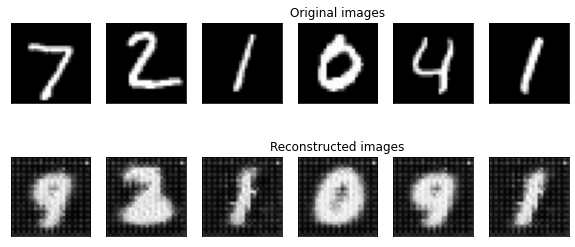

	 partial train loss (single batch): 13060.480469
	 partial train loss (single batch): 13263.723633
	 partial train loss (single batch): 12935.445312
	 partial train loss (single batch): 13367.708008
	 partial train loss (single batch): 12768.633789
	 partial train loss (single batch): 13352.072266
	 partial train loss (single batch): 12979.928711
	 partial train loss (single batch): 13070.904297
	 partial train loss (single batch): 13224.781250
	 partial train loss (single batch): 13021.984375
	 partial train loss (single batch): 13320.333008
	 partial train loss (single batch): 13019.506836
	 partial train loss (single batch): 12846.009766
	 partial train loss (single batch): 13317.201172
	 partial train loss (single batch): 13010.746094
	 partial train loss (single batch): 13205.200195
	 partial train loss (single batch): 12926.551758
	 partial train loss (single batch): 12955.724609
	 partial train loss (single batch): 12663.234375
	 partial train loss (single batch): 12870.782227


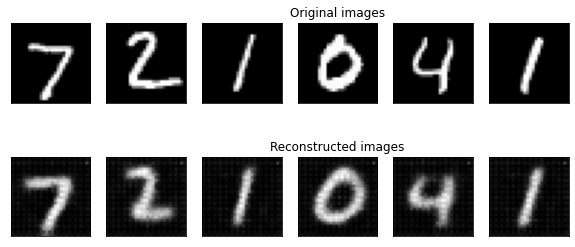

	 partial train loss (single batch): 9967.946289
	 partial train loss (single batch): 9909.273438
	 partial train loss (single batch): 10410.027344
	 partial train loss (single batch): 10109.305664
	 partial train loss (single batch): 9924.036133
	 partial train loss (single batch): 10070.930664
	 partial train loss (single batch): 10017.373047
	 partial train loss (single batch): 9979.051758
	 partial train loss (single batch): 10095.905273
	 partial train loss (single batch): 9974.332031
	 partial train loss (single batch): 10302.913086
	 partial train loss (single batch): 10363.044922
	 partial train loss (single batch): 10337.419922
	 partial train loss (single batch): 10169.142578
	 partial train loss (single batch): 10030.855469
	 partial train loss (single batch): 9996.854492
	 partial train loss (single batch): 10113.172852
	 partial train loss (single batch): 9963.082031
	 partial train loss (single batch): 10242.378906
	 partial train loss (single batch): 9765.769531
	 partia

KeyboardInterrupt: 

In [37]:
num_epochs = 50

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)


